<a href="https://colab.research.google.com/github/DJCordhose/ai/blob/master/notebooks/tf2/rnn-add-example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Addition as a Sequence to Sequence Translation
Adapted from https://github.com/keras-team/keras/blob/master/examples/addition_rnn.py

In [1]:
!pip install -q tf-nightly-gpu-2.0-preview

     |████████████████████████████████| 346.4MB 59kB/s 
     |████████████████████████████████| 430kB 51.3MB/s 
     |████████████████████████████████| 61kB 29.5MB/s 
     |████████████████████████████████| 3.1MB 44.4MB/s 
ERROR: thinc 6.12.1 has requirement wrapt<1.11.0,>=1.10.0, but you'll have wrapt 1.11.1 which is incompatible.


In [2]:
import tensorflow as tf
print(tf.__version__)

2.0.0-dev20190502


### Step 1: Generate sample equations

In [0]:
class CharacterTable(object):
    """Given a set of characters:
    + Encode them to a one hot integer representation
    + Decode the one hot integer representation to their character output
    + Decode a vector of probabilities to their character output
    """
    def __init__(self, chars):
        """Initialize character table.

        # Arguments
            chars: Characters that can appear in the input.
        """
        self.chars = sorted(set(chars))
        self.char_indices = dict((c, i) for i, c in enumerate(self.chars))
        self.indices_char = dict((i, c) for i, c in enumerate(self.chars))

    def encode(self, C, num_rows):
        """One hot encode given string C.

        # Arguments
            num_rows: Number of rows in the returned one hot encoding. This is
                used to keep the # of rows for each data the same.
        """
        x = np.zeros((num_rows, len(self.chars)))
        for i, c in enumerate(C):
            x[i, self.char_indices[c]] = 1
        return x

    def decode(self, x, calc_argmax=True):
        if calc_argmax:
            x = x.argmax(axis=-1)
        return ''.join(self.indices_char[x] for x in x)


In [0]:
class colors:
    ok = '\033[92m'
    fail = '\033[91m'
    close = '\033[0m'

In [6]:
import numpy as np

# Parameters for the model and dataset.
TRAINING_SIZE = 50000
DIGITS = 3
# REVERSE = True
REVERSE = False

# Maximum length of input is 'int + int' (e.g., '345+678'). Maximum length of
# int is DIGITS.
MAXLEN = DIGITS + 1 + DIGITS

# All the numbers, plus sign and space for padding.
chars = '0123456789+ '
ctable = CharacterTable(chars)

questions = []
expected = []
seen = set()
print('Generating data...')
while len(questions) < TRAINING_SIZE:
    f = lambda: int(''.join(np.random.choice(list('0123456789'))
                    for i in range(np.random.randint(1, DIGITS + 1))))
    a, b = f(), f()
    # Skip any addition questions we've already seen
    # Also skip any such that x+Y == Y+x (hence the sorting).
    key = tuple(sorted((a, b)))
    if key in seen:
        continue
    seen.add(key)
    # Pad the data with spaces such that it is always MAXLEN.
    q = '{}+{}'.format(a, b)
    query = q + ' ' * (MAXLEN - len(q))
    ans = str(a + b)
    # Answers can be of maximum size DIGITS + 1.
    ans += ' ' * (DIGITS + 1 - len(ans))
    if REVERSE:
        # Reverse the query, e.g., '12+345  ' becomes '  543+21'. (Note the
        # space used for padding.)
        query = query[::-1]
    questions.append(query)
    expected.append(ans)
print('Total addition questions:', len(questions))

Generating data...
Total addition questions: 50000


In [13]:
questions[0]

'506+0  '

In [14]:
expected[0]

'506 '

In [8]:
print('Vectorization...')
x = np.zeros((len(questions), MAXLEN, len(chars)), dtype=np.bool)
y = np.zeros((len(questions), DIGITS + 1, len(chars)), dtype=np.bool)
for i, sentence in enumerate(questions):
    x[i] = ctable.encode(sentence, MAXLEN)
for i, sentence in enumerate(expected):
    y[i] = ctable.encode(sentence, DIGITS + 1)


Vectorization...


In [9]:
len(x[0])

7

In [10]:
len(questions[0])

7

### Input is encoded as one-hot, 7 digits times 12 possibilities

In [12]:
x[0]

array([[False, False, False, False, False, False, False,  True, False,
        False, False, False],
       [False, False,  True, False, False, False, False, False, False,
        False, False, False],
       [False, False, False, False, False, False, False, False,  True,
        False, False, False],
       [False,  True, False, False, False, False, False, False, False,
        False, False, False],
       [False, False,  True, False, False, False, False, False, False,
        False, False, False],
       [ True, False, False, False, False, False, False, False, False,
        False, False, False],
       [ True, False, False, False, False, False, False, False, False,
        False, False, False]])

### Same for output, but at most 4 digits

In [15]:
y[0]

array([[False, False, False, False, False, False, False,  True, False,
        False, False, False],
       [False, False,  True, False, False, False, False, False, False,
        False, False, False],
       [False, False, False, False, False, False, False, False,  True,
        False, False, False],
       [ True, False, False, False, False, False, False, False, False,
        False, False, False]])

In [0]:
# Shuffle (x, y) in unison as the later parts of x will almost all be larger
# digits.
indices = np.arange(len(y))
np.random.shuffle(indices)
x = x[indices]
y = y[indices]

### Step 2: Training/Validation Split

In [17]:
# Explicitly set apart 10% for validation data that we never train over.
split_at = len(x) - len(x) // 10
(x_train, x_val) = x[:split_at], x[split_at:]
(y_train, y_val) = y[:split_at], y[split_at:]

print('Training Data:')
print(x_train.shape)
print(y_train.shape)

print('Validation Data:')
print(x_val.shape)
print(y_val.shape)

Training Data:
(45000, 7, 12)
(45000, 4, 12)
Validation Data:
(5000, 7, 12)
(5000, 4, 12)


### Step 3: Create Model

In [18]:
# input shape: 7 digits, each being 0-9, + or space (12 possibilities)
MAXLEN, len(chars)

(7, 12)

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import  LSTM, GRU, SimpleRNN, Dense, RepeatVector

# Try replacing LSTM, GRU, or SimpleRNN.
# RNN = LSTM
RNN = SimpleRNN # should be enough since we do not have long sequences and only local dependencies
# RNN = GRU
HIDDEN_SIZE = 128
BATCH_SIZE = 128

model = Sequential()
# encoder 
model.add(RNN(units=HIDDEN_SIZE, input_shape=(MAXLEN, len(chars))))

# latent space
encoding_dim = 32
model.add(Dense(units=encoding_dim, activation='relu', name="encoder"))

# decoder: have 4 temporal outputs one for each of the digits of the results
model.add(RepeatVector(DIGITS + 1))

# return_sequences=True tells it to keep all 4 temporal outputs, not only the final one (we need all four digits for the results)
model.add(RNN(units=HIDDEN_SIZE, return_sequences=True))

model.add(Dense(name='classifier', units=len(chars), activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_4 (SimpleRNN)     (None, 128)               18048     
_________________________________________________________________
encoder (Dense)              (None, 32)                4128      
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 4, 32)             0         
_________________________________________________________________
simple_rnn_5 (SimpleRNN)     (None, 4, 128)            20608     
_________________________________________________________________
classifier (Dense)           (None, 4, 12)             1548      
Total params: 44,332
Trainable params: 44,332
Non-trainable params: 0
_________________________________________________________________


### Step 4: Train

In [24]:
%%time

# Train the model each generation and show predictions against the validation
# dataset.

merged_losses = {
    "loss": [],
    "val_loss": [],
    "accuracy": [],
    "val_accuracy": [],
    
}

for iteration in range(1, 50):
    print()
    print('-' * 50)
    print('Iteration', iteration)
    iteration_history = model.fit(x_train, y_train,
              batch_size=BATCH_SIZE,
              epochs=1,
              validation_data=(x_val, y_val))
    
    merged_losses["loss"].append(iteration_history.history["loss"])
    merged_losses["val_loss"].append(iteration_history.history["val_loss"])
    merged_losses["accuracy"].append(iteration_history.history["accuracy"])
    merged_losses["val_accuracy"].append(iteration_history.history["val_accuracy"])

    # Select 10 samples from the validation set at random so we can visualize
    # errors.
    for i in range(10):
        ind = np.random.randint(0, len(x_val))
        rowx, rowy = x_val[np.array([ind])], y_val[np.array([ind])]
        preds = model.predict_classes(rowx, verbose=0)
        q = ctable.decode(rowx[0])
        correct = ctable.decode(rowy[0])
        guess = ctable.decode(preds[0], calc_argmax=False)
        print('Q', q[::-1] if REVERSE else q, end=' ')
        print('T', correct, end=' ')
        if correct == guess:
            print(colors.ok + '☑' + colors.close, end=' ')
        else:
            print(colors.fail + '☒' + colors.close, end=' ')
        print(guess)


--------------------------------------------------
Iteration 1
Train on 45000 samples, validate on 5000 samples
45000/45000 [==============================] - 6s 123us/sample - loss: 1.6689 - accuracy: 0.3896 - val_loss: 1.5134 - val_accuracy: 0.4410
Q 658+775 T 1433 ☒ 1407
Q 557+41  T 598  ☒ 666 
Q 660+44  T 704  ☒ 666 
Q 79+411  T 490  ☒ 444 
Q 684+760 T 1444 ☒ 1406
Q 4+844   T 848  ☒ 548 
Q 816+42  T 858  ☒ 891 
Q 644+68  T 712  ☒ 623 
Q 500+83  T 583  ☒ 603 
Q 9+667   T 676  ☒ 666 

--------------------------------------------------
Iteration 2
Train on 45000 samples, validate on 5000 samples
45000/45000 [==============================] - 5s 102us/sample - loss: 1.3752 - accuracy: 0.4873 - val_loss: 1.2841 - val_accuracy: 0.5138
Q 97+760  T 857  ☒ 882 
Q 914+5   T 919  ☒ 912 
Q 72+60   T 132  ☒ 146 
Q 915+21  T 936  ☒ 991 
Q 734+101 T 835  ☒ 851 
Q 3+39    T 42   ☒ 39  
Q 175+17  T 192  ☒ 261 
Q 411+66  T 477  ☒ 591 
Q 82+50   T 132  ☒ 146 
Q 663+7   T 670  ☒ 664 

---------------

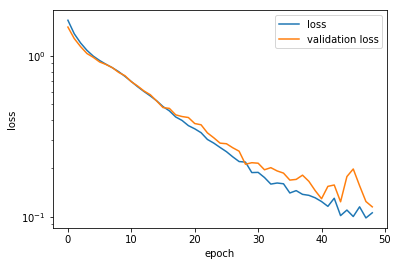

In [25]:
import matplotlib.pyplot as plt

plt.ylabel('loss')
plt.xlabel('epoch')
plt.yscale('log')

plt.plot(merged_losses['loss'])
plt.plot(merged_losses['val_loss'])

plt.legend(['loss', 'validation loss'])

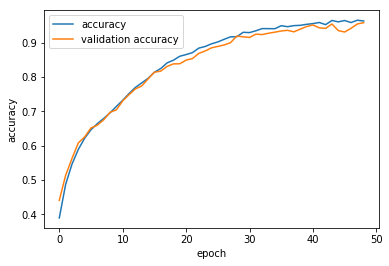

In [27]:
plt.ylabel('accuracy')
plt.xlabel('epoch')
# plt.yscale('log')

plt.plot(merged_losses['accuracy'])
plt.plot(merged_losses['val_accuracy'])

plt.legend(['accuracy', 'validation accuracy'])